# AE/VAE on binarised MNIST

In this tutorial, we'll play a bit with a binarised version of MNIST. We'll train an autoencoder on it and a variational autoencoder.

# Loading useful stuff

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions

# Loading MNIST and binarising it

In [3]:
(train_images_nonbinary, y_train), (test_images_nonbinary,  y_test) = tf.keras.datasets.mnist.load_data()

train_images_nonbinary = train_images_nonbinary.reshape(train_images_nonbinary.shape[0], 28*28)
test_images_nonbinary = test_images_nonbinary.reshape(test_images_nonbinary.shape[0], 28*28)

y_train = tf.cast(y_train, tf.int32)
y_test =tf.cast(y_test, tf.int32)

11501568/11490434 [==============================] - 0s 0us/step


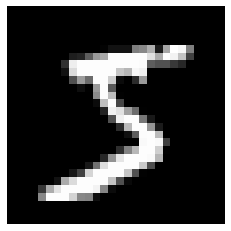

In [4]:
plt.imshow(train_images_nonbinary[0, :].reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

Then we binarise the data. There are many ways to do that. Here, we simply round the numbers, following the [TF tutorial on convolutional VAEs](https://www.tensorflow.org/tutorials/generative/cvae).

In [5]:
# Normalizing the images to the range of [0., 1.]
train_images = train_images_nonbinary/255.
test_images = test_images_nonbinary/255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

train_images = tf.cast(train_images, tf.float32)
test_images = tf.cast(test_images, tf.float32)



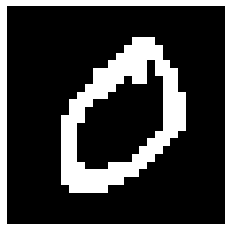

In [7]:
plt.imshow(train_images[1, :].numpy().reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images,y_train)).shuffle(60000).batch(32) # TF creates the batches for us

## Regular Auto-Encoder

Let us start with a regular auto-encoder. We want to encode (or compress) the data into a low-dimensional embedding.


*   The low-dimensional subspace $\mathbb{R}^d$ is the **code space**.

*   The decoder is a function $$\text{Decoder}_{\theta_{decoder}} : \mathbb{R}^d \longrightarrow [0,1]^{28 \times 28}$$ that will transform low-dimensional codes into distributions over images.

*   Conversely, the encoder is a function $$\text{Encoder}_{\theta_{encoder}} : \{0,1\}^{28 \times 28} \longrightarrow \mathbb{R}^d$$ that will encode the images in low-dimensional space.

* Both functions are parametrised by (deep) neural nets whose weigths are stored in $\theta_{decoder}$ and $\theta_{encoder}$.












 The loss function is the **average reconstruction error**:

$$\ell_{AE}(\theta_{encoder},\theta_{decoder}) = \sum_{i=1}^n \text{Xentropy}(x_i,\text{Decoder}_{\theta_{decoder}}(\text{Encoder}_{\theta_{encoder}}(x_i)).$$

Indeed, we want to be able to **reconstruct (approximately) the original data using only the low-dimensional embeddings**.

In [9]:
h = 200 # number of hidden units
sigma = "relu" # activation function
d = 2

encoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[28*28,]),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(d),
])

In [10]:
decoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[d,]),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(28*28), # I don't use a sigmoid here because TF will use it inside tf.nn.sigmoid_cross_entropy_with_logits
])

In [11]:
@tf.function
def reconstruction_error(data):
  reconstruction_parameters = decoder(encoder(data))
  reconstruction_errors = tf.nn.sigmoid_cross_entropy_with_logits(labels = data, logits = reconstruction_parameters)
  return tf.reduce_mean(reconstruction_errors)

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
theta_ae = encoder.trainable_variables + decoder.trainable_variables

In [14]:
@tf.function
def train_step_ae(data):
  with tf.GradientTape() as tape: # the gradient tape saves all the step that needs to be saved fopr automatic differentiation
    loss = reconstruction_error(data)  # the loss is the average reconstruction error (cross-entropy)
  gradients = tape.gradient(loss, theta_ae)  # here, the gradient is automatically computed
  optimizer.apply_gradients(zip(gradients, theta_ae))  # Adam iteration

In [15]:
EPOCHS = 15

for epoch in range(1,EPOCHS+1):
  for images, labels in train_dataset:
    train_step_ae(images) # Adam iteration
  train_error = reconstruction_error(train_images)
  test_error = reconstruction_error(test_images)
  if (epoch % 5) == 1:
    print('Epoch  %g' %epoch)
    print('Train reconstruction error  %g' %train_error.numpy())
    print('Test reconstruction error  %g' %test_error.numpy())
    print('-----------')

Epoch  1
Train reconstruction error  0.189572
Test reconstruction error  0.189811
-----------
Epoch  6
Train reconstruction error  0.167091
Test reconstruction error  0.168654
-----------
Epoch  11
Train reconstruction error  0.161844
Test reconstruction error  0.164317
-----------


In [16]:
reconstruction_error(test_images)

<tf.Tensor: shape=(), dtype=float32, numpy=0.16386364>

Let's look at the faitfulness of the reconstructions:

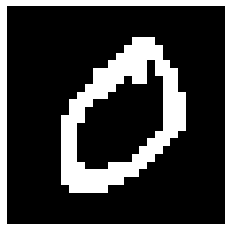

In [17]:
plt.imshow(train_images[1:2, :].numpy().reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

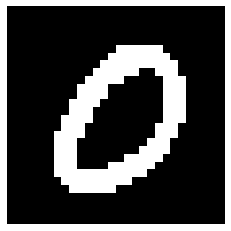

In [20]:
plt.imshow((decoder(encoder(train_images[1:2, :])).numpy().reshape((28,28))>0), cmap='gray')
plt.axis('off')
plt.show()

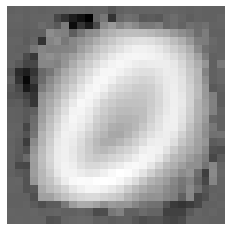

In [19]:
plt.imshow((decoder(encoder(train_images[1:2, :])).numpy().reshape((28,28))), cmap='gray')
plt.axis('off')
plt.show()

Questions:


1. Write down the mathematical formulas for the encoder and decoder defined via Keras.
2.   Does the decoder output binary or continuous images? Would it be possible to change that?
3.   Try to plot the low-dimensional representation.



1. $$\text{Decoder}_{\theta_{decoder}} : \mathbb{R}^d \longrightarrow [0,1]^{28 \times 28}$$

$$\text{Decoder}_{\theta_{decoder}} : \mathbf{x} \mapsto \sigma (W_2 \text{ReLU}(W_1\text{ReLU}(W_0x + b_0) + b_1 ) + b_2). $$

2. Continuous! It can't be changed easily because it would not be differentiable. We can't train a binary decoder because of this, but we can use thresholding after training to obtain binary images.

In [22]:
low_dim_rep = encoder(train_images).numpy()

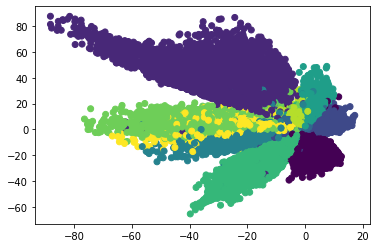

In [24]:
plt.scatter(low_dim_rep[:,0],low_dim_rep[:,1], c = y_train)

**This simple auto-encoder is not a probabilistic model! A VAE is a probabilistic version of it that allows to also sample new "fake" images (among many other applications).**

# Simple generative modelling

Before training a VAE, we start with a very dumb generative model as an appetizer.

We build here a **super simple** generative model for the data set. Specifically, the model is simply a product of Bernoulli distributions:
$$p (\textbf{x}) = \prod_{j = 1}^{28 \times 28} \mathcal{B}(x_j|\pi_j).$$

Training can simply be done by computing the means of all the pixels independently (and add a small regularisation factor):

In [25]:
pis_bern = train_images.numpy().mean(0)  + 1e-9

In [26]:
prod_of_bernoullis =  tfd.Independent(distribution  = tfd.Bernoulli(probs = pis_bern), reinterpreted_batch_ndims = 1)

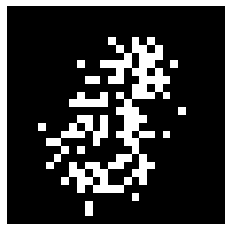

In [28]:
sample_pofbern = tf.reshape(prod_of_bernoullis.sample(1),(28,28))
plt.imshow(sample_pofbern, cmap='gray')
plt.axis('off')
plt.show()

Why is this clearly a pretty bad model?

We usually assess the quality of such generative models by computing the **test log-likelihood**. Here, we can do that easily because the model is simple:

In [29]:
tf.reduce_mean(prod_of_bernoullis.log_prob(test_images)).numpy()

-205.84882

The state of the art for binarised versions of MNIST is around -75, which is much higher than that! Using a VAE (or an IWAE), we'll try to close the gap a bit!

# VAE: defining a deep latent variable model and its inference network

We will use a **deep latent variable model with a Gaussian prior and a Bernoulli observation model**. This can be written:

$$p_{\boldsymbol{\theta}}(\mathbf{x}_1,...,\mathbf{x}_n) = \prod_{i=1}^n p(\mathbf{x}_i|\mathbf{z}_i)p(\mathbf{z}_i),$$
$$p(\mathbf{z}_i) = \mathcal{N}(\mathbf{z}_i|\mathbf{0}_d,\mathbf{I}_d), $$
$$p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z}_i) = \mathcal{B} (\mathbf{x}_i|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i)),$$

where $\boldsymbol{\pi}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow [0,1]^p$ is a function (called the **decoder**) parametrised by a deep neural net.

In [91]:
d = 2 # dimension of the latent space

p_z = tfd.Independent(tfd.Normal(loc = tf.zeros(d, tf.float32), scale = tf.ones(d, tf.float32)),reinterpreted_batch_ndims=1)  # that's the prior

In [92]:
h = 200 # number of hidden units
sigma = "relu" # activation function

decoder_vae = tfk.Sequential([
  tfkl.InputLayer(input_shape=[d,]),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(28*28), # No need to use the logistic to ensure that the output is in [0,1] here, it will be done later
])

To be able to train our model, we will need an **encoder** (aka **inference network**), that will allow us to approximate the intractable posterior $p(\mathbf{z}|\mathbf{x})$.
The approximate posterior is defined as follows
$$ q(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mathbf{z} | \mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x} ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x} )),
$$ 
where $\mathbf{x} \mapsto (\mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x} ), \mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x} ))$ is a function from the data space (i.e. $\{0,1\}^p$) to $\mathbb{R}^d \times [0, \infty[^d$ parametrised by a deep neural network. In other words, the encoder outputs the mean and the diagonal of the covariance matrix of the approximate posterior $q(\mathbf{z}|\mathbf{x})$.

In [93]:
encoder_vae = tfk.Sequential([
  tfkl.InputLayer(input_shape=[28*28,]),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(2*d), 
])

# Sampling from the deep generative model

Before we train it, let's look at some samples from the model.

In [94]:
@tf.function
def vae_sample(num_samples):
  codes = p_z.sample(num_samples)
  out_decoder = decoder_vae(codes)
  p_xgivenz = tfd.Independent(tfd.Bernoulli(out_decoder), reinterpreted_batch_ndims = 1)
  return p_xgivenz.sample(1)

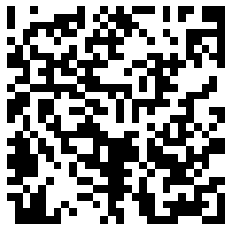

In [95]:
plt.imshow(vae_sample(1).numpy().reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

They look really bad... But we haven't started training yet!

# Training a VAE

The **VAE objective** is defined as
$$
\mathcal{L}_1 (\boldsymbol{\theta,\gamma}) = \sum_{i=1}^n \mathbb{E}_{\mathbf{z} \sim q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)} \left[ \log\frac{p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z})p(\mathbf{z})}{q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)} \right].
$$

It is a lower bound of the likelihood of the deep latent variable model. Rather than the intractable likelihood, we'll **maximise this bound**.

To see more clearly the neural nets inside the objective, we may rewrite it as:
$$
\mathcal{L}_1 (\boldsymbol{\theta,\gamma}) = \sum_{i=1}^n \mathbb{E}_{\mathbf{z} \sim \mathcal{N}(\mathbf{z} | \mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x}_i ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x}_i ))} \left[ \log\frac{\mathcal{B} (\mathbf{x}_i|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}))\mathcal{N}(\mathbf{z}|\mathbf{0}_d,\mathbf{I}_d)}{\mathcal{N}(\mathbf{z} | \mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x}_i ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x}_i ))} \right].
$$

**Create a TF function that computes an unbiased estimate of it!** (using a single sample from the approximate posterior)

A good way to go is to follow these steps, for all $\mathbf{x}_i$ in your batch:


*   Encode the batch fo data points, to get the $\mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x}_i ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x}_i ))$ 
*   Use these encoder outputs to define $q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)$ as a TF probability distribution
*   Take one sample $\mathbf{z}_i$ from $q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)$, and use it to:
  *   Compute $\mathcal{B} (\mathbf{x}_i|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i))$ by decoding $\mathbf{z}_i$
  *   Compute the rest of the log of $p(\mathbf{z}_i)$ and $q_{\boldsymbol{\gamma}}(\mathbf{z}_i|\mathbf{x}_i)$ using the $\texttt{.logprob}$ method from TF probability.






In [96]:
@tf.function
def vae_bound(batch):

  encoded_batch = encoder_vae(batch)
  mu_q = encoded_batch[:,:d]
  sigma_q = tf.math.abs(encoded_batch[:,d:])

  q_zgivenx = tfd.Independent(tfd.Normal(loc = mu_q, scale = sigma_q) ,reinterpreted_batch_ndims=1)
  z_sample = q_zgivenx.sample(1)

  decoded_batch = decoder_vae(tf.squeeze(z_sample))

  p_xgivenz = tfd.Independent(distribution  = tfd.Bernoulli(logits = decoded_batch), reinterpreted_batch_ndims = 1)

  log_p_xgivenz = p_xgivenz.log_prob(batch)
  log_p_z = p_z.log_prob(z_sample)
  log_q_zgivenx = q_zgivenx.log_prob(z_sample) 

  L_VAE = tf.reduce_mean(log_p_xgivenz + log_p_z - log_q_zgivenx)

  return L_VAE 

In [97]:
params_vae = encoder_vae.trainable_variables + decoder_vae.trainable_variables 
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)


In [98]:
@tf.function
def train_step_vae(data):
  with tf.GradientTape() as tape: # the gradient tape saves all the step that needs to be saved fopr automatic differentiation
    loss = -vae_bound(data)  # the loss is the average negative VAE bound
  gradients = tape.gradient(loss, params_vae)  # here, the gradient is automatically computed
  optimizer.apply_gradients(zip(gradients, params_vae))  # Adam iteration

In [99]:
EPOCHS = 32

for epoch in range(1,EPOCHS+1):
  for images, labels in train_dataset:
    train_step_vae(images) # Adam iteration
  train_bound = vae_bound(train_images)
  test_bound = vae_bound(test_images)
  if (epoch % 5) == 1:
    print('Epoch  %g' %epoch)
    print('Train bound  %g' %train_bound.numpy())
    print('Test bound  %g' %test_bound.numpy())
    print('-----------')

Epoch  1
Train bound  -191.707
Test bound  -190.972
-----------
Epoch  6
Train bound  -169.472
Test bound  -169.212
-----------
Epoch  11
Train bound  -163.971
Test bound  -164.341
-----------
Epoch  16
Train bound  -161.661
Test bound  -162.261
-----------
Epoch  21
Train bound  -158.318
Test bound  -159.009
-----------
Epoch  26
Train bound  -155.468
Test bound  -156.461
-----------
Epoch  31
Train bound  -152.878
Test bound  -153.819
-----------


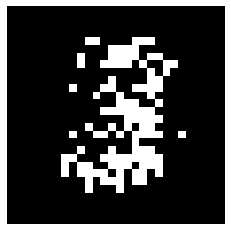

In [104]:
plt.imshow(vae_sample(1).numpy().reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()